In [1]:
import time
import random
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import uuid
import pandas as pd
import numpy as np

In [2]:
#reference: https://jrtechs.net/data-science/implementing-a-quadtree-in-python

## Node class

In [3]:
# Node class is a square in the quardtree
# with (x0, y0) as coordinates, w as width and height, children as four children nodes

In [4]:
from typing import NamedTuple

class Node(NamedTuple):
    x0: int
    y0: int
    width: int
    children: list
    parent: list
    id: int

## QTree class

In [5]:
# QTree class which can do the divide and graph of quardtree
class QTree():
    def __init__(self):
        self.root = Node(0, 0, 1000, [], None, uuid.uuid4().hex[:4])
        self.leaf_list = [self.root]
        self.parent_list = []
    def subdivide(self, index):
        node = self.leaf_list[index]
        w_ = float(node.width/2)
        x1 = Node(node.x0, node.y0, w_,[], [node], uuid.uuid4().hex[:4])
        x2 = Node(node.x0, node.y0+w_, w_, [], [node], uuid.uuid4().hex[:4])
        x3 = Node(node.x0 + w_, node.y0, w_, [], [node], uuid.uuid4().hex[:4])
        x4 = Node(node.x0+w_, node.y0+w_, w_, [], [node], uuid.uuid4().hex[:4])
        if node.parent != None and node.parent[0] in self.parent_list:
            self.parent_list.remove(node.parent[0])
        #x1, x2, x3, x4 becomes the children of the node
        node.children.append(x1)
        node.children.append(x2)
        node.children.append(x3)
        node.children.append(x4)
        # the original node is not leaf node any longer
        self.leaf_list.pop(index)
        # the generated four children nodes are added to the leaf list
        self.leaf_list.append(x1)
        self.leaf_list.append(x2)
        self.leaf_list.append(x3)
        self.leaf_list.append(x4)
        # the original node becomes the parent node
        self.parent_list.append(node)
        
    def weld(self, index):
        node = self.parent_list[index]
        # the original node is not parent node any longer
        self.parent_list.pop(index)
        # all children nodes are removed from leaf list
        self.leaf_list.remove(node.children[0])
        self.leaf_list.remove(node.children[1])
        self.leaf_list.remove(node.children[2])
        self.leaf_list.remove(node.children[3])
        # the original node becomse the leaf node
        self.leaf_list.append(node)
        node.children.clear()
        
    def graph(self):
        fig, ax = plt.subplots(figsize=(8, 8))
        plt.title("Quadtree")
        ax.set_xlim(0, 1000)
        ax.set_ylim(0, 1000)
        c = self.leaf_list
        print("Number of segments: %d" %len(c))
        areas = set()
        for el in c:
            areas.add(el.width*el.width)
        print("Minimum segment area: %.3f units" %min(areas))
        for n in c:
            #print((n.x0, n.y0), n.width, n.height)
            rect = patches.Rectangle((n.x0, n.y0), n.width, n.width, fill=False)
            ax.add_patch(rect)
        patches_list = ax.patches
        plt.show()

## Method about find the size distribution and plotting

In [6]:
# FIND the dictionary of leave nodes' size(sorted)
from collections import OrderedDict      # ordered dictionary is used for sorted the size

def find_size(node):
    if not node.children:
        size = node.width * node.width
        return {size: 1}
    else:
        sizes = {}
        for child in node.children:
            child_sizes = find_size(child)
            for child_size, count in child_sizes.items():
                if child_size in sizes:
                    sizes[child_size] += count
                else:
                    sizes[child_size] = count
        sorted_sizes = OrderedDict(sorted(sizes.items()))
        return sorted_sizes

# plot the size distribution
def plot_size_distribution(size_distribution):
    sizes = list(size_distribution.keys())
    counts = list(size_distribution.values())
    print("sizes: ", sizes)
    print("counts: ",counts)
    plt.plot(sizes, counts, marker='o', linestyle='-')
    plt.xlabel('Node Size')
    plt.ylabel('Count')
    plt.title('Size Distribution of ice floes')
    plt.show()

## Visualization (not required)

In [7]:
# sudo apt install -y graphviz
# pip3 install graphviz
from graphviz import Graph, Digraph

In [8]:
# FIND the dictionary of all nodes id that can be divide(the leaf)
def find_children_id(node):
    if not node.children:
        return [node.id]
    else:
        children = []
        for child in node.children:
            children +=(find_children_id(child))
    return children

# FIND the dictionary of all nodes id that can be fuse(the parent)
def find_parents_id(node):
    if len(node.children) != 4:
        return []
    else: 
        parent = [node.id]
        for child in node.children:
            parent += find_parents_id(child)
        return parent

In [9]:
# draw the nodes in a tree graph
def tree_graph(node, g):
    if node.children == []:
        return g
    for child in node.children:
        g.edge(node.id, child.id)
        tree_graph(child, g)
    return g

## Example

In [10]:
import random
# example of using QTreee 
quard = QTree()

# Divide random times between 0 and 5
for i in range(2):
    # Divide random parent node
    index = random.randint(0,len(quard.leaf_list)-1)
    #print("Divide: ", find_children(quard.root)[index].id)
    quard.subdivide(index)

# # Weld random times between 0 and 5
# for i in range(random.randint(0, 10)):
#     # Weld random child node to a parent node
#     if len(find_parents(quard.root)) == 0:
#         break
#     if len(find_parents(quard.root)) == 1:
#         #print("Weld the children of: ", find_parents(quard.root)[0].id)
#         quard.weld(find_parents(quard.root)[0])
#         break
#     index = random.randint(0,len(find_parents(quard.root))-1)
#     #print("Weld the children of: ", find_parents(quard.root)[index].id)
#     quard.weld(find_parents(quard.root)[index])
#quard.graph() 

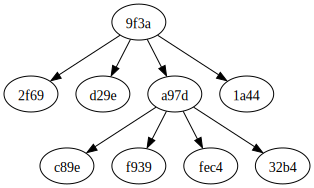

In [11]:
g = Digraph()
tree_graph(quard.root, g)

Number of segments: 7
Minimum segment area: 62500.000 units


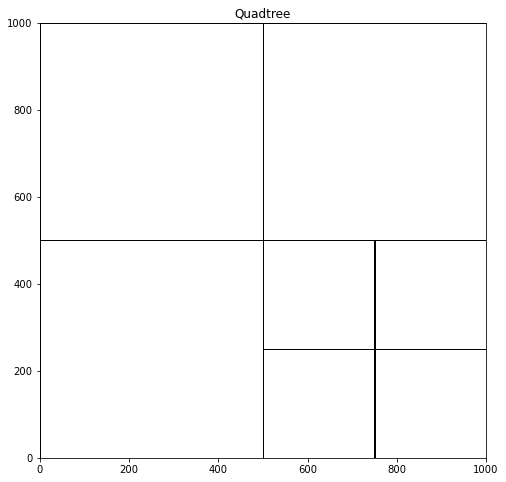

In [12]:
quard.graph() 

sizes:  [62500.0, 250000.0]
counts:  [4, 3]


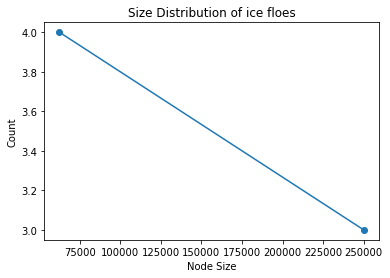

In [13]:
# the size distribution of the tree
size_distribution = find_size(quard.root)
plot_size_distribution(size_distribution)

In [14]:
[x.id for x in quard.leaf_list]

['2f69', 'd29e', '1a44', 'c89e', 'f939', 'fec4', '32b4']

In [15]:
[x.id for x in quard.parent_list]

['a97d']

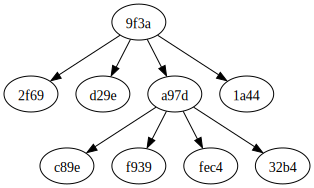

In [16]:
g = Digraph()
tree_graph(quard.root, g)

## Simulation

### A simple random choice based on probability of divide, weld rate

In [17]:
class Python_Switch:
    def behave(self, num, quard):
        default = "Error input: input should be integer from 0 to 2"
        self.quard = quard
        return getattr(self, 'case_' + str(num), lambda: default)()
    
    def case_0(self):
        # nothing happen
        return 

    def case_1(self):
        # divde
        index = random.randint(0,len(self.quard.leaf_list)-1)
        self.quard.subdivide(index)

    
    def case_2(self):
        if len(self.quard.parent_list) == 1 or len(self.quard.parent_list) == 0:
            return
        # weld
        index = random.randint(0,len(self.quard.parent_list)-1)
        self.quard.weld(index)

In [18]:
# 0: nothing happen
# 1: fracture
# 2: weld
def spilt_weld_simulate(spilt_rate, weld_rate, second):
    quard_example = QTree()
    if spilt_rate + weld_rate > 1:
        print("Error: invalid input, possibility larger than 1")
    nothing_rate = 1 - spilt_rate - weld_rate
    population = [0,1,2]
    weights = [nothing_rate, spilt_rate, weld_rate]
    for i in range(10000*second):
        num = random.choices(population, weights)[0]
        switch = Python_Switch()
        switch.behave(num, quard_example)
    size_distribution = find_size(quard_example.root)
    plot_size_distribution(size_distribution)
    quard_example.graph()
    return quard_example

sizes:  [2.1684043449710089e-13, 8.673617379884035e-13, 3.469446951953614e-12, 1.3877787807814457e-11, 5.551115123125783e-11, 2.220446049250313e-10, 8.881784197001252e-10, 3.552713678800501e-09, 1.4210854715202004e-08, 5.6843418860808015e-08, 2.2737367544323206e-07, 9.094947017729282e-07, 3.637978807091713e-06, 1.4551915228366852e-05, 5.820766091346741e-05, 0.00023283064365386963, 0.0009313225746154785, 0.003725290298461914, 0.014901161193847656, 0.059604644775390625, 0.2384185791015625, 0.95367431640625, 3.814697265625, 15.2587890625, 61.03515625, 244.140625, 976.5625, 3906.25, 15625.0, 62500.0]
counts:  [4, 19, 31, 39, 84, 128, 182, 301, 395, 635, 895, 1297, 1724, 2343, 3094, 3699, 4133, 4356, 3852, 3474, 2722, 2084, 1434, 910, 523, 242, 112, 59, 23, 3]


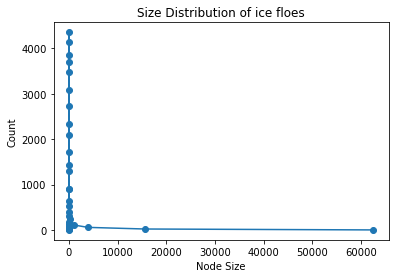

Number of segments: 38797
Minimum segment area: 0.000 units


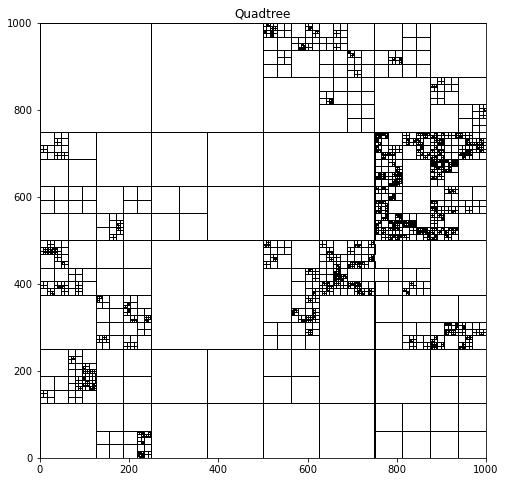

In [19]:
quard_50000times = spilt_weld_simulate(0.554,0.3,5)

## Check whether the size distribution is a powerlaw distribtuion

In [20]:
# install by `pip install powerlaw`
import powerlaw
import matplotlib.pyplot as plt

def check_power_law_distribution(size_distribution):
    sizes = list(size_distribution.keys())
    counts = list(size_distribution.values())

    # Fit power law model
    fit = powerlaw.Fit(sizes, xmin=min(sizes))

    # Plot the distribution and power law fit
    fit.plot_ccdf(color='r', linewidth=2)
    fit.power_law.plot_ccdf(color='g', linestyle='--', ax=plt.gca())

    # Perform goodness-of-fit test
    R, p_value = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)

    if p_value < 0.05:
        print("The size distribution is not a good fit for a power law distribution.")
    else:
        print("The size distribution is a good fit for a power law distribution.")

    plt.xlabel('Node Size')
    plt.ylabel('Complementary Cumulative Distribution Function (CCDF)')
    plt.title('Size Distribution and Power Law Fit')
    plt.show()

The size distribution is not a good fit for a power law distribution.


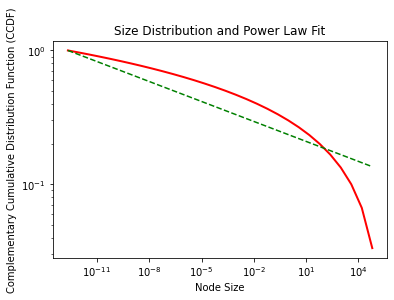

In [21]:
# Usage:
size_distribution = find_size(quard_50000times.root)
check_power_law_distribution(size_distribution)